<a href="https://colab.research.google.com/github/RitikaHiremath/DataScience/blob/main/src/ipynb_notebooks/LSTM_Networks_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import numpy as np

def load_and_label_data(base_path, label, max_files=None):
    combined_100KHzdata = []
    combined_2000KHzdata = []

    file_counter = 0

    for timestamp_folder in os.listdir(base_path):
        if max_files and file_counter >= max_files:
            break

        timestamp_folder_path = os.path.join(base_path, timestamp_folder, "raw")
        timestamp = timestamp_folder.split('_')[0] + '_' + timestamp_folder.split('_')[1]
        timestamp = pd.to_datetime(timestamp, format='%Y.%m.%d_%H.%M.%S')

        # Process 2000KHz data
        df_2000KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling2000KHz_AEKi-0.parquet"))
        df_2000KHz_grouped = df_2000KHz.groupby(df_2000KHz.index // 10000).mean().reset_index(drop=True)
        df_2000KHz_grouped['timestamp'] = timestamp + pd.to_timedelta(df_2000KHz_grouped.index, unit='ms')
        df_2000KHz_grouped['label'] = label

        # Process 100KHz data
        df_100KHz = pd.read_parquet(os.path.join(timestamp_folder_path, "Sampling100KHz_Irms_Grinding-Grinding spindle current L1-Grinding spindle current L2-Grinding spindle current L3-0.parquet"))
        df_100KHz_grouped = df_100KHz.groupby(df_100KHz.index // 10000).mean().reset_index(drop=True)
        df_100KHz_grouped['timestamp'] = timestamp + pd.to_timedelta(df_100KHz_grouped.index, unit='ms')
        df_100KHz_grouped['label'] = label

        combined_100KHzdata.append(df_100KHz_grouped)
        combined_2000KHzdata.append(df_2000KHz_grouped)

        file_counter += 1

    final_combined_100KHzdata = pd.concat(combined_100KHzdata, ignore_index=True)
    final_combined_2000KHzdata = pd.concat(combined_2000KHzdata, ignore_index=True)

    return final_combined_100KHzdata, final_combined_2000KHzdata

def preprocess_data(ok_data_path, nok_data_path):
    ok_100KHzdata, ok_2000KHzdata = load_and_label_data(ok_data_path, label=0)
    nok_100KHzdata, nok_2000KHzdata = load_and_label_data(nok_data_path, label=1)

    all_100KHzdata = pd.concat([ok_100KHzdata, nok_100KHzdata], ignore_index=True)
    all_2000KHzdata = pd.concat([ok_2000KHzdata, nok_2000KHzdata], ignore_index=True)

    return all_100KHzdata, all_2000KHzdata

def combine_and_interpolate_data(data_100KHz, data_2000KHz):
    # Merge on timestamp
    combined_data = pd.merge_asof(data_100KHz.sort_values('timestamp'),
                                  data_2000KHz.sort_values('timestamp'),
                                  on='timestamp',
                                  by='label',
                                  direction='nearest')

    # Interpolate to fill missing values
    combined_data = combined_data.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

    return combined_data
def normalize_data(combined_data):
    features = combined_data.drop(columns=['timestamp', 'label'])
    timestamps = combined_data['timestamp']
    labels = combined_data['label']

    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    normalized_data = pd.DataFrame(normalized_features, columns=features.columns)
    normalized_data.insert(0, 'timestamp', timestamps)
    normalized_data['label'] = labels.values

    return normalized_data

def create_labeled_sequences(data, sequence_length=10):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length, 1:-1].values
        label = data.iloc[i+sequence_length - 1, -1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [2]:
import tensorflow as tf
from tensorflow.keras.losses import Loss

class CustomLoss(Loss):
    def __init__(self, name="custom_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1, 1]), dtype=tf.float32)  # Ensure y_true is the same shape and type as y_pred
        y_pred = tf.cast(y_pred, dtype=tf.float32)  # Ensure y_pred is float32
        main_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        auxiliary_loss = self.calculate_auxiliary_loss(y_true, y_pred)
        total_loss = main_loss + auxiliary_loss
        return total_loss

    @tf.function
    def calculate_auxiliary_loss(self, y_true, y_pred):
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        return mse_loss

    def get_config(self):
        base_config = super(CustomLoss, self).get_config()
        return base_config


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape, kernel_regularizer='l2'))
    model.add(Dropout(0.2))
    model.add(LSTM(50, kernel_regularizer='l2'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss=CustomLoss(), metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    return model

def train_model(model, X_combined, y_combined):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_combined, y_combined,
        epochs=50,
        batch_size=8,
        validation_split=0.3,
        callbacks=[early_stopping]
    )
    return history

def train_model(model, X_combined, y_combined):
    # Shuffle the data to ensure proper training
    X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        X_combined, y_combined,
        epochs=50,  # Reduced number of epochs
        batch_size=16,  # Increased batch size to reduce noise
        validation_split=0.3,
        callbacks=[early_stopping]
    )

    return history

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    # Evaluate the model to get loss and accuracy
    evaluation_metrics = model.evaluate(X, y, verbose=0)
    loss = evaluation_metrics[0]
    accuracy = evaluation_metrics[1]

    # Calculate precision, recall, and F1 score
    precision = precision_score(y, y_pred_classes)
    recall = recall_score(y, y_pred_classes)
    f1 = f1_score(y, y_pred_classes)

    # Print the classification report
    print(classification_report(y, y_pred_classes))

    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    return loss, accuracy, precision, recall, f1


In [4]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


Epoch 1/50
373/373 [==============================] - 13s 17ms/step - loss: 0.9424 - accuracy: 0.6764 - precision: 0.7417 - recall: 0.4204 - val_loss: 0.6174 - val_accuracy: 0.8063 - val_precision: 0.7957 - val_recall: 0.7801
Epoch 2/50
373/373 [==============================] - 3s 9ms/step - loss: 0.6410 - accuracy: 0.7942 - precision: 0.7842 - recall: 0.7426 - val_loss: 0.6101 - val_accuracy: 0.8023 - val_precision: 0.7660 - val_recall: 0.8226
Epoch 3/50
373/373 [==============================] - 3s 9ms/step - loss: 0.6237 - accuracy: 0.8014 - precision: 0.7919 - recall: 0.7520 - val_loss: 0.5871 - val_accuracy: 0.8063 - val_precision: 0.8079 - val_recall: 0.7606
Epoch 4/50
373/373 [==============================] - 3s 9ms/step - loss: 0.6184 - accuracy: 0.8005 - precision: 0.7938 - recall: 0.7463 - val_loss: 0.5856 - val_accuracy: 0.8023 - val_precision: 0.7849 - val_recall: 0.7869
Epoch 5/50
373/373 [==============================] - 5s 12ms/step - loss: 0.6183 - accuracy: 0.7973 -

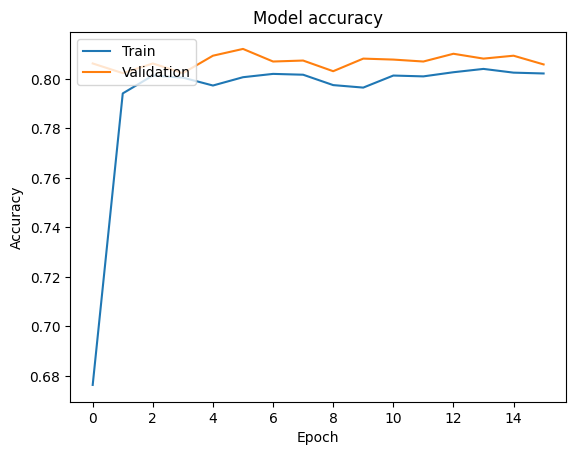

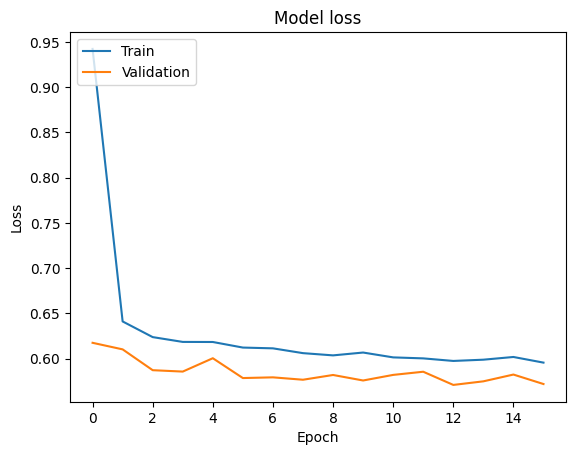

267/267 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      4681
           1       0.81      0.75      0.78      3835

    accuracy                           0.81      8516
   macro avg       0.81      0.80      0.81      8516
weighted avg       0.81      0.81      0.81      8516



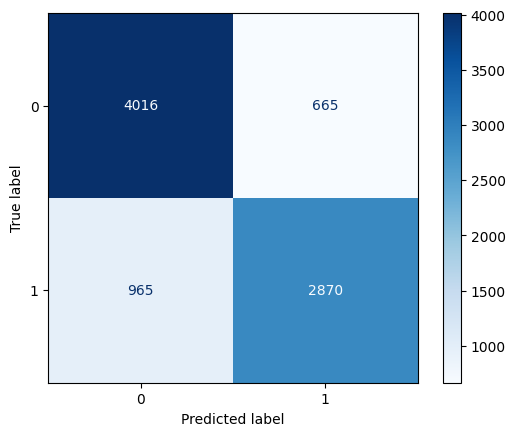

Training Loss: 0.5793, Training Accuracy: 80.86%, Training Precision: 0.81, Training Recall: 0.75, Training F1 Score: 0.78
115/115 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1921
           1       0.84      0.74      0.79      1730

    accuracy                           0.81      3651
   macro avg       0.81      0.81      0.81      3651
weighted avg       0.81      0.81      0.81      3651



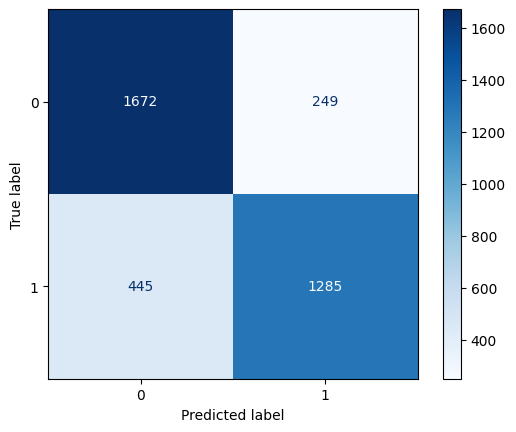

Test Loss: 0.5735, Test Accuracy: 80.99%, Test Precision: 0.84, Test Recall: 0.74, Test F1 Score: 0.79

Results Summary:
    Dataset      Loss  Accuracy  Precision    Recall  F1 Score
0  Training  0.579281  0.808596   0.811881  0.748370  0.778833
1      Test  0.573498  0.809915   0.837679  0.742775  0.787377


In [7]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Define paths to data
ok_data_path = '/content/gdrive/MyDrive/Data/OK_Measurements'
nok_data_path = '/content/gdrive/MyDrive/Data/NOK_Measurements'

# Preprocess data
all_100KHzdata, all_2000KHzdata = preprocess_data(ok_data_path, nok_data_path)

# Combine and interpolate data
combined_data = combine_and_interpolate_data(all_100KHzdata, all_2000KHzdata)


# Normalize data
normalized_data = normalize_data(combined_data)

# Shuffle the combined data
normalized_data = shuffle(normalized_data, random_state=42)

# Create labeled sequences
sequence_length = 10
X_combined, y_combined = create_labeled_sequences(normalized_data, sequence_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# Create LSTM model
input_shape_combined = (sequence_length, X_combined.shape[2])
model_combined = create_lstm_model(input_shape_combined)

# Train the model
history = train_model(model_combined, X_train, y_train)

# Save the model
model_combined.save('AEGuard.keras')

# Plot results
plot_accuracy(history)
plot_loss(history)

# Evaluate the model on training data
train_loss, train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model_combined, X_train, y_train)
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy*100:.2f}%, Training Precision: {train_precision:.2f}, Training Recall: {train_recall:.2f}, Training F1 Score: {train_f1:.2f}")

# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_combined, X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%, Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1 Score: {test_f1:.2f}")

# Create a results table
results = {
    "Dataset": ["Training", "Test"],
    "Loss": [train_loss, test_loss],
    "Accuracy": [train_accuracy, test_accuracy],
    "Precision": [train_precision, test_precision],
    "Recall": [train_recall, test_recall],
    "F1 Score": [train_f1, test_f1]
}

results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)
